In [5]:
include("/home/n/nichollsh/lovepy/TidalLoveNumbers.jl")
using .TidalLoveNumbers
using Plots
using Printf
using DoubleFloats

# Get precision of Love number module (e.g., Float64, Double64, etc)
prec = TidalLoveNumbers.prec;    # Type of real numbers
precc = TidalLoveNumbers.precc;  # TYpe of complex numbers

In [6]:
gr()

Plots.GRBackend()

In [7]:
struct rheo_t
    dotl::prec
    delta::prec
    xi::prec
    gamma::prec
    phist::prec
end

B_ein::prec = 2.5

2.5

In [140]:
# Lookup parameters for rheological properties
# Taken from https://doi.org/10.1051/0004-6361/202039433
par_visc  = rheo_t(1.0,  25.7, 1.17e-9, 5.0, 0.4)
par_shear = rheo_t(10.0, 2.10, 7.08e-7, 5.0, 0.4)
par_bulk  = rheo_t(1e9,  2.62, 0.102,   5.0, 0.4)


rheo_t(1.0e9, 2.62, 0.102, 5.0, 0.4)

In [141]:

# Evalulate big Phi at a given layer
function _bigphi(phi, par)
    return (1.0-phi)/(1.0-par.phist)
end

# Evalulate big F at a given layer
function _bigf(phi, par)
    numer = sqrt(pi) * _bigphi(phi, par) * (1.0 + _bigphi(phi, par)^par.gamma)
    denom = 2.0 * (1.0 - par.xi)
    return (1.0-par.xi) * erf(numer/denom)
end

# Evalulate rheological parameter at a given layer
function eval_rheoparam(phi, which)
    if which == "visc"
        par = par_visc
    elseif which == "shear"
        par = par_shear
    elseif which == "bulk"
        par = par_bulk
    end
    # Evaluate parameter
    numer = 1.0 + _bigphi(phi, par)^par.delta
    denom = (1.0-_bigf(phi, par)) ^ (B_ein*(1-par.phist))
    return par.dotl * numer / denom
end


eval_rheoparam (generic function with 1 method)

In [233]:
# Rotational and orbital parameters
day = 2.0
ecc = 0.05
ω = 2 * pi / (day * 24 * 60 * 60)     # Orbital frequency (2π / orbital period)
phi = 0.05
nlev=40


40

In [234]:
mask = Int(nlev/2):nlev

20:40

In [235]:
shear = eval_rheoparam(phi, "shear")
@printf("Shear = %.3e \n", shear)
visc = eval_rheoparam(phi, "visc")
@printf("Visc = %.3e \n", visc)
bulk = eval_rheoparam(phi, "bulk")
;

Shear = 6.085e+10 
Visc = 3.363e+18 


In [260]:
Rp = 6.0

# Create a toy, homogeneous Enceladus-ish model
ρ = ones(prec, nlev) * 4300.0  # Bulk density of each layer (kg m^-3)
r = collect(prec, range(3.0, Rp, length=nlev+1)) * 1e6                 # Outer radius of solid surface
μ = ones(prec, nlev) * shear         # Elastic shear modulus of each layer (Pa)
κ = ones(prec, nlev) * bulk    # Bulk modulus of each layer (set to a large number for incompressible material) (GPa)
η = ones(prec, nlev) * visc        # Shear viscosity of each layer (Pa s)

top_shear = eval_rheoparam(phi, "shear")
top_visc = eval_rheoparam(phi, "visc")
top_bulk = eval_rheoparam(phi, "bulk")

μ[mask] .= eval_rheoparam(0.3, "shear")
η[mask] .= eval_rheoparam(0.3, "visc")
κ[mask] .= eval_rheoparam(0.3, "bulk")

@printf("Viscosity: %.2e Pa s \n", η[end])


μc = 1im * μ*ω ./ (1im*ω .+ μ./η)       # Complex shear modulus for a Maxwell material. Change this for different rheologies.
R = r[end]
rr = expand_layers(r, nr=10)            # Expand the layers to a finer grid for numerical integration
g = get_g(rr, ρ);                       # Get the gravitational acceleration on the fine grid
tidal_solution = calculate_y(rr, ρ, g, μc, κ)       # Get "y-functions"
Edot_vol = get_heating_profile(tidal_solution, rr, ρ, g, μc, κ, ω, ecc, res=10.0) # Get volumetric heating profile (W/m^3)
full_x = 1e9 * Edot_vol ./ ρ # Convert to mass heating rate (W/kg)
full_r = r[2:end]
;

Viscosity: 7.25e+09 Pa s 


In [261]:
Rp = 4.5

# Create a toy, homogeneous Enceladus-ish model
ρ = ones(prec, nlev) * 4300.0  # Bulk density of each layer (kg m^-3)
r = collect(prec, range(3.0, Rp, length=nlev+1)) * 1e6                 # Outer radius of solid surface
μ = ones(prec, nlev) * shear         # Elastic shear modulus of each layer (Pa)
κ = ones(prec, nlev) * bulk    # Bulk modulus of each layer (set to a large number for incompressible material) (GPa)
η = ones(prec, nlev) * visc        # Shear viscosity of each layer (Pa s)


μc = 1im * μ*ω ./ (1im*ω .+ μ./η)       # Complex shear modulus for a Maxwell material. Change this for different rheologies.
R = r[end]
rr = expand_layers(r, nr=10)            # Expand the layers to a finer grid for numerical integration
g = get_g(rr, ρ);                       # Get the gravitational acceleration on the fine grid
tidal_solution = calculate_y(rr, ρ, g, μc, κ)       # Get "y-functions"
Edot_vol = get_heating_profile(tidal_solution, rr, ρ, g, μc, κ, ω, ecc, res=10.0) # Get volumetric heating profile (W/m^3)
part_x = 1e9 * Edot_vol ./ ρ # Convert to mass heating rate (W/kg)
part_r = r[2:end]
;

In [262]:
Rp = 6.0

# Create a toy, homogeneous Enceladus-ish model
ρ = ones(prec, nlev) * 4300.0  # Bulk density of each layer (kg m^-3)
r = collect(prec, range(3.0, Rp, length=nlev+1)) * 1e6                 # Outer radius of solid surface
μ = ones(prec, nlev) * shear         # Elastic shear modulus of each layer (Pa)
κ = ones(prec, nlev) * bulk    # Bulk modulus of each layer (set to a large number for incompressible material) (GPa)
η = ones(prec, nlev) * visc        # Shear viscosity of each layer (Pa s)

μc = 1im * μ*ω ./ (1im*ω .+ μ./η)       # Complex shear modulus for a Maxwell material. Change this for different rheologies.
R = r[end]
rr = expand_layers(r, nr=10)            # Expand the layers to a finer grid for numerical integration
g = get_g(rr, ρ);                       # Get the gravitational acceleration on the fine grid
tidal_solution = calculate_y(rr, ρ, g, μc, κ)       # Get "y-functions"
Edot_vol = get_heating_profile(tidal_solution, rr, ρ, g, μc, κ, ω, ecc, res=10.0) # Get volumetric heating profile (W/m^3)
hybr_x = 1e9 * Edot_vol ./ ρ # Convert to mass heating rate (W/kg)
hybr_r = r[2:end]
;

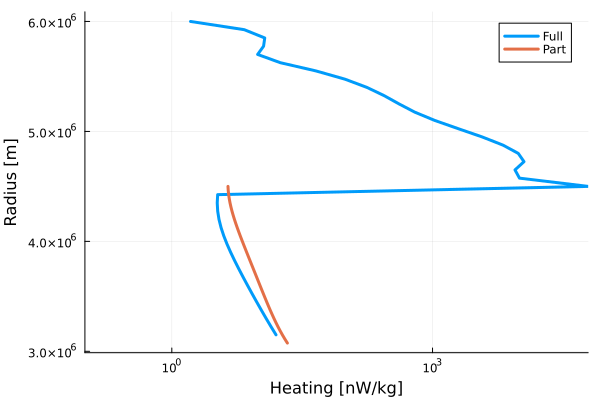

In [263]:
fig = plot(xlims=(0.1, Inf), xscale=:log10, xlabel="Heating [nW/kg]", ylabel="Radius [m]")

plot!(full_x[2:end], full_r[2:end], lw=3, label="Full")
plot!(part_x[2:end], part_r[2:end], lw=3, label="Part")
# plot!(hybr_x[2:end], hybr_r[2:end], lw=3, label="Hybr", linestyle=:dash, color=:black)

display(fig)